In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding,Flatten,Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import shuffle
print(tf.__version__)
sns.set()
np.random.seed(10)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


In [2]:
rating_df = pd.read_csv('ratings.csv')
rating_df['datetime']= pd.to_datetime(rating_df['timestamp'],unit='s')
rating_df.head(2)

,userId,movieId,rating,timestamp,datetime
0,1,2,3.5,1112486027,2005-04-02 23:53:47
1,1,29,3.5,1112484676,2005-04-02 23:31:16


In [3]:
# converting IDs to categorical data type
rating_df['movieId'] = rating_df['movieId'].astype(np.object)
rating_df['userId'] = rating_df['userId'].astype(np.object)
rating_df.describe(include=np.object)

,userId,movieId
count,20000263,20000263
unique,138493,26744
top,118205,296
freq,9254,67310


In [4]:
rating_df['rating'].describe()

count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [5]:
rating_df['datetime'].describe()

count                20000263
unique               15351121
top       1996-03-01 00:00:00
freq                      643
first     1995-01-09 11:46:44
last      2015-03-31 06:40:02
Name: datetime, dtype: object

In [6]:
# ecnoding Ids to 0 to n-1 as embedding layer expected input as indexes from 0 to n-1 for n categories
movie_encoder = LabelEncoder()
user_encoder = LabelEncoder()
rating_df['movie_enc'] = movie_encoder.fit_transform(rating_df['movieId'])
rating_df['user_enc'] = user_encoder.fit_transform(rating_df['userId'])

In [7]:
rating_df[['movie_enc','user_enc']].describe()

,movie_enc,user_enc
count,2.000026e+07,2.000026e+07
mean,3.602899e+03,6.904487e+04
std,4.136939e+03,4.003863e+04
min,0.000000e+00,0.000000e+00
25%,8.850000e+02,3.439400e+04
50%,2.083000e+03,6.914000e+04
75%,4.674000e+03,1.036360e+05
max,2.674300e+04,1.384920e+05


In [8]:
# sorting basis datetime for train test split
sort_df = rating_df.sort_values(by='datetime')

# train test split 
train_size = 0.80
train_idx = int(sort_df.shape[0] * train_size)
train_df = sort_df[:train_idx].copy()
test_df = sort_df[train_idx:].copy()

# shuffling train and test data
train_df = shuffle(train_df)
test_df = shuffle(test_df)

print("Train shape {}".format(train_df.shape))
print("Test shape {}".format(test_df.shape))

Train shape (16000210, 7)
Test shape (4000053, 7)


In [9]:
print("Train date range {} to {}".format(train_df['datetime'].min(),train_df['datetime'].max()))
print("Test date range {} to {}".format(test_df['datetime'].min(),test_df['datetime'].max()))

Train date range 1995-01-09 11:46:44 to 2009-10-20 07:33:38
Test date range 2009-10-20 07:33:43 to 2015-03-31 06:40:02


In [10]:
# standarized rating
scaler = StandardScaler()
train_df['std_rating'] = scaler.fit_transform(train_df['rating'].values.reshape(-1,1)) 
test_df['std_rating'] = scaler.transform(test_df['rating'].values.reshape(-1,1)) 

In [23]:
# no of unique user and movie
n_user = rating_df['user_enc'].nunique() 
n_movie = rating_df['movie_enc'].nunique() 

# output size for embedding layer
out_dim = 5


# Input Layer 1 - User input
user = Input(shape=(1,))

# embedding layer for user id
user_emb = Embedding(n_user,out_dim)(user)

# Input Layer 2 - Movie Input
movie = Input(shape=(1,))

# embedding layer for user id
movie_emb = Embedding(n_user,out_dim)(movie)

# flatten both input 
# flattening makes embeeding layer output into one single vector instead of vector of sequences
user_emb = Flatten()(user_emb)
movie_emb = Flatten()(movie_emb)

# concatentate to form final input feature vectors
x = Concatenate()([user_emb,movie_emb])

# feed it to ANN for rating prediction
x = Dense(128,activation='relu')(x)
# x = Dense(64,activation='relu')(x)
# x = Dense(32,activation='relu')(x)

# output
x = Dense(1,activation=None)(x)

# Model
model = Model(inputs=[user,movie],outputs=x)

In [24]:
# Compile
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(loss='mse',optimizer=optimizer)

In [25]:
# training
hist = model.fit(x=[train_df['user_enc'].values,train_df['movie_enc'].values],
                 y= train_df['std_rating'].values,
                 validation_data=([test_df['user_enc'].values,test_df['movie_enc'].values],test_df['std_rating'].values),
                 batch_size=1024,epochs=20)

Epoch 1/20
15626/15626 [==============================] - 72s 5ms/step - loss: 0.9989 - val_loss: 0.9237
Epoch 2/20
15626/15626 [==============================] - 73s 5ms/step - loss: 0.9941 - val_loss: 0.9184
Epoch 3/20
15626/15626 [==============================] - 70s 4ms/step - loss: 0.9826 - val_loss: 0.9065
Epoch 4/20
15626/15626 [==============================] - 70s 4ms/step - loss: 0.9550 - val_loss: 0.8821
Epoch 5/20
15626/15626 [==============================] - 70s 4ms/step - loss: 0.9128 - val_loss: 0.8604
Epoch 6/20
15626/15626 [==============================] - 70s 4ms/step - loss: 0.8793 - val_loss: 0.8493
Epoch 7/20
15626/15626 [==============================] - 72s 5ms/step - loss: 0.8575 - val_loss: 0.8421
Epoch 8/20
15626/15626 [==============================] - 72s 5ms/step - loss: 0.8424 - val_loss: 0.8382
Epoch 9/20
15626/15626 [==============================] - 71s 5ms/step - loss: 0.8318 - val_loss: 0.8356
Epoch 10/20
15626/15626 [==============================

In [26]:
# Check accuracy on test dataset
predict = model.predict([test_df['user_enc'].values,test_df['movie_enc'].values])
print('Test mean square error {}'.format(mean_squared_error(test_df['std_rating'],predict)))

Test mean square error 0.8253873764272471


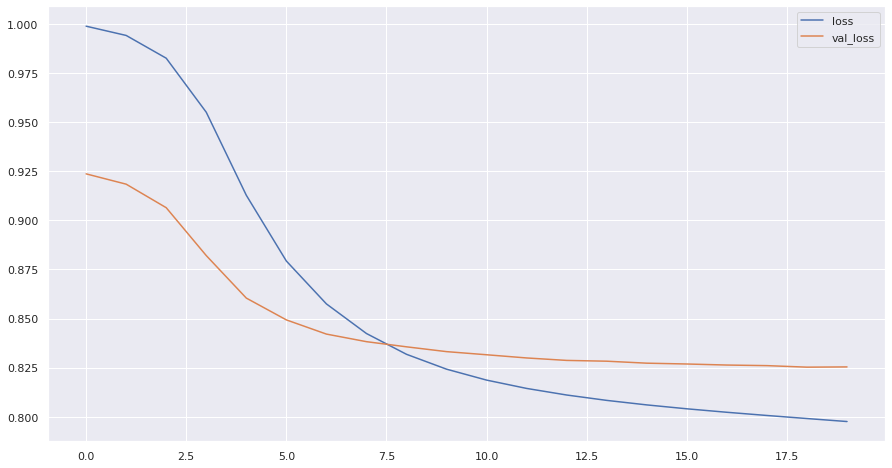

In [27]:
# plot loss 
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()

In [28]:
test_df['predicted_ratings'] = scaler.inverse_transform(predict)
test_df[['userId','movieId','rating','predicted_ratings']].sample(10)

,userId,movieId,rating,predicted_ratings
5564151,38251,541,4.5,4.151030
6432972,44189,3186,4.5,3.558151
14167437,97828,72380,2.5,3.336419
19979125,138325,8338,4.5,3.796371
7711291,53095,1136,4.5,4.207299
9860146,68155,2501,4.5,3.948684
6093501,41988,2762,5.0,4.094682
18800070,130204,2795,4.5,3.796962
6888263,47439,64197,4.5,3.452749
961125,6447,1805,2.0,3.176520
